In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils

import numpy as np
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import time
import os
from os.path import join, exists
import copy
import random
import re

from tqdm import tqdm

from torch.nn import functional as F
import torchvision.transforms.functional as TF

from torchvision.models import Inception3
from mk_cam import *
from mk_mask import *
from naive_method import *

# Create one to one reference mapping

In [12]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1.pickle', 'rb') as f:
    reference_mapping = pickle.load(f)

In [37]:
correction = {'6083_381069_2010': '6083_381069_2007', '8031_213465_2012': '8031_213465_2011', 
             '9003_225995_2012': '9003_225995_2006', '34029_34700_2016': '34029_34700_2010'}
original_dir = '/home/ubuntu/projects/data/deepsolar2/labeled1116'
reference_mapping_single = {}
for target_path in reference_mapping:
    folder = target_path.split('/')[-1][:-11]
    if not folder in os.listdir(original_dir):
        folder = correction[folder]
        
    with open(join(original_dir, folder, 'img_info.txt'), 'r') as f:
        lr_images = f.readlines()
    lr_images = set([x[:-1] for x in lr_images])
    
    ref_path_HR_list = []
    for ref_path in sorted(reference_mapping[target_path]):
        if ref_path.split('/')[-1][-10:] not in lr_images:
            ref_path_HR_list.append(ref_path)
    reference_mapping_single[target_path] = [ref_path_HR_list[0]]

In [39]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1_single.pickle', 'wb') as f:
    pickle.dump(reference_mapping_single, f)

In [40]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_2.pickle', 'rb') as f:
    reference_mapping = pickle.load(f)

In [59]:
correction = {'48453_473659_2015': '48453_473659_2014'}
original_dir = '/home/ubuntu/projects/data/deepsolar2/labeled1206'
reference_mapping_single = {}
for target_path in reference_mapping:
    folder = target_path.split('/')[-1][:-11]
    if not folder in os.listdir(original_dir):
        folder = correction[folder]
    
    with open(join(original_dir, folder, 'img_info.txt'), 'r') as f:
        lr_images = f.readlines()
    lr_images = set([x[:-1] for x in lr_images])
    
    ref_path_HR_list = []
    for ref_path in sorted(reference_mapping[target_path]):
        if ref_path.split('/')[-1][-10:] not in lr_images:
            ref_path_HR_list.append(ref_path)
    if len(ref_path_HR_list) == 0:
        reference_mapping_single[target_path] = [reference_mapping[target_path][0]]
    else:
        reference_mapping_single[target_path] = [ref_path_HR_list[0]]

In [61]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_2_single.pickle', 'wb') as f:
    pickle.dump(reference_mapping_single, f)

# Modify reference mapping

In [154]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1_single.pickle', 'rb') as f:
    reference_mapping = pickle.load(f)
reference_mapping_new = {}
correction = {'6083_381069_2010': '6083_381069_2007', '8031_213465_2012': '8031_213465_2011', 
             '9003_225995_2012': '9003_225995_2006', '34029_34700_2016': '34029_34700_2010'}
# correction = {'48453_473659_2015': '48453_473659_2014'}
for target_path in reference_mapping:
    folder = target_path.split('/')[-1][:-11]
    new_ref_list = []
    for ref_path in reference_mapping[target_path]:
        folder_ref = ref_path.split('/')[-1][:-11]
        if folder_ref in correction:
            ref_path = ref_path.replace(folder_ref, correction[folder_ref])
        new_ref_list.append(ref_path)
    if folder in correction:
        target_path = target_path.replace(folder, correction[folder])
    reference_mapping_new[target_path] = new_ref_list

In [155]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1_single.pickle', 'wb') as f:
    pickle.dump(reference_mapping_new, f)

In [156]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1.pickle', 'rb') as f:
    reference_mapping = pickle.load(f)
reference_mapping_new = {}
correction = {'6083_381069_2010': '6083_381069_2007', '8031_213465_2012': '8031_213465_2011', 
             '9003_225995_2012': '9003_225995_2006', '34029_34700_2016': '34029_34700_2010'}
# correction = {'48453_473659_2015': '48453_473659_2014'}
for target_path in reference_mapping:
    folder = target_path.split('/')[-1][:-11]
    new_ref_list = []
    for ref_path in reference_mapping[target_path]:
        folder_ref = ref_path.split('/')[-1][:-11]
        if folder_ref in correction:
            ref_path = ref_path.replace(folder_ref, correction[folder_ref])
        new_ref_list.append(ref_path)
    if folder in correction:
        target_path = target_path.replace(folder, correction[folder])
    reference_mapping_new[target_path] = new_ref_list

In [157]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1.pickle', 'wb') as f:
    pickle.dump(reference_mapping_new, f)

# Binarize

In [144]:
bi_trans = NaiveMethod()

Loaded existing model parameters from: /home/ubuntu/projects/historical_solar/checkpoint/deepsolar_seg_pretrained.pth


In [166]:
with open('/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_2_single.pickle', 'rb') as f:
    reference_mapping = pickle.load(f)
data_dir = '/home/ubuntu/projects/data/deepsolar2/cleaned/LR_2'
bi_data_dir = '/home/ubuntu/projects/data/deepsolar2/cleaned/LR_2_binary'

In [167]:
for x in ['train', 'val', 'test']:
    if not exists(join(bi_data_dir, x)):
        os.mkdir(join(bi_data_dir, x))
    for c in ['0', '1', 'ref']:
        if not exists(join(bi_data_dir, x, c)):
            os.mkdir(join(bi_data_dir, x, c))

In [168]:
count = 0
for target_path in tqdm(reference_mapping):
    if exists(join(data_dir, target_path)):
        count += 1
print(count)

100%|██████████| 7879/7879 [00:00<00:00, 177201.94it/s]

6469


In [169]:
for target_path in tqdm(reference_mapping):
    if not exists(join(data_dir, target_path)):
        continue
    ref_path = reference_mapping[target_path][0]
    ref_bi, large_mask = bi_trans.perform_extract(join(data_dir, ref_path), is_ref=1)
    tar_bi = bi_trans.perform_extract(join(data_dir, target_path), is_ref=0, large_mask=large_mask)
    if not exists(join(bi_data_dir, ref_path)):
        cv2.imwrite(join(bi_data_dir, ref_path), ref_bi)
    cv2.imwrite(join(bi_data_dir, target_path), tar_bi)

100%|██████████| 7879/7879 [22:31<00:00,  5.07it/s]


# Test the ImagePairDataset implementation

In [2]:
from image_dataset import *
import skimage

In [82]:
data_dirs = ['/home/ubuntu/projects/data/deepsolar2/cleaned/LR_0_binary/test',
            '/home/ubuntu/projects/data/deepsolar2/cleaned/LR_1_binary/test',
            '/home/ubuntu/projects/data/deepsolar2/cleaned/LR_2_binary/test']
reference_mapping_paths = ['/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_0.pickle',
                          '/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_1_single.pickle',
                          '/home/ubuntu/projects/data_preparation/reference_mapping/reference_mapping_LR_2_single.pickle']

In [83]:
transform_func = transforms.Compose([                
        transforms.Resize((299, 299)),
        transforms.ToTensor()])

In [84]:
ds = ImagePairDataset(root_dirs=data_dirs, 
                      reference_mapping_paths=reference_mapping_paths, 
                      is_train=False, 
                      binary=True,
                      transform = transform_func)

In [85]:
len(ds)

3588

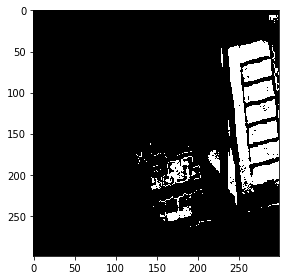

In [127]:
skimage.io.imshow(ds[1000][0].numpy()[0])

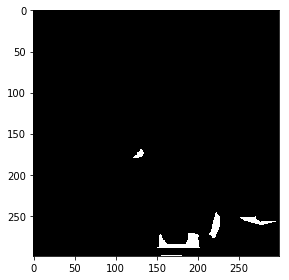

In [128]:
skimage.io.imshow(ds[1000][1].numpy()[0])

In [130]:
ds[1000][2]

0